In [1]:
from multiprocessing import Pool,Process,Manager,cpu_count
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt
import scipy as sp
import cmath
import time 
import math
import uproot as rt

%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

from tabulate import tabulate as tb

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list or type(Files) is np.ndarray):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def TwoDGaussianElliptical(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()
        
def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def MaskCreate(pixel,radius,center,plot=False,sp="Circle"):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=0
    values=np.zeros(rr.shape)
    if(sp=="Rectangle"):
        rr[centerX-radius[0] :centerX+radius[0],centerY-radius[1] :centerY+radius[1]]=-1
        mask=rr==-1
        mask=mask.transpose()
    else:
        mask=rr<radius
        
    values[mask]=1       
    
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower",vmin=values.min(),vmax=values.max())
        plt.show()
    
    return mask,values,[centerX,centerY]




def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1).optimize
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()

def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    positions=np.where(MaskIn)
    print("XXX\n")
    print(grid[0])
    print("YYY\n")
    print(grid[1])
    print("RRR\n")

    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmax
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value



def RadialAverage(pws,radius,Amou,center=None):
    xp=np.arange(pws.shape[0])
    yp=np.arange(pws.shape[0])
    xx,yy=np.meshgrid(xp,yp)
    pws=np.fft.fftshift(pws)
    if not center:
        center=[pws.shape[0]/2,pws.shape[0]/2]
    R=np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    
    radial = lambda r:pws[(R>=r-0.5) & (R<r+0.5)].mean()
    r=np.arange(1,radius,1)
    PWS1D=np.vectorize(radial)(r)
    return PWS1D

def my_ceil(a, precision=0):
    return np.true_divide(np.ceil(a * 10**precision), 10**precision)

def my_floor(a, precision=0):
    return np.true_divide(np.floor(a * 10**precision), 10**precision)



In [27]:
## Create the Camera Frame
def SimulatedImages(path,Single=False):
    Simages={}
    Files=ListofFiles(path)
    Count=0
    UsableFiles=[]
    
    for i in range(0,len(Files)):
        if(Files[i][-4:]!="root"):
            continue
        UsableFiles.append(Files[i])
     
    for i in range(0,len(UsableFiles)):
       
        print(f"Analyzing {i+1} out of {len(UsableFiles)} the following root file {UsableFiles[i]}\n")    
        file=rt.open(UsableFiles[i])
        Event=file["ntuple/Camera/Event"].array()
        X=file["ntuple/Camera/X"].array()
        Y=file["ntuple/Camera/Y"].array()
        Z=file["ntuple/Camera/Z"].array()
        theta=-np.pi/8
        costet=np.cos(theta)
        sintet=np.sin(theta)
        pixelsize=0.016

        XRotated=(X*costet-sintet*Y)
        YRotated=-(X*sintet+costet*Y)
        
        XRotated=((XRotated)/(pixelsize*3))+260+30
        YRotated=((YRotated)/(pixelsize*3)+230+40)
        
        XRotated=np.array(XRotated)
        YRotated=np.array(YRotated)
        
        from matplotlib.colors import LogNorm
        
        #plt.figure(figsize=(15,15),dpi=300)
        #plt.imshow(Images2[4],cmap=plt.cm.jet,origin='lower')
        #plt.imshow(Images[200],cmap=plt.cm.jet,origin='lower',alpha=0.5)
        #plt.title("Simulated 10 bar")
        #plt.xlabel("Pixel X")
        #plt.ylabel("Pixel Y")

        #h2=np.histogram2d(XRotated,YRotated,bins=[np.arange(0,512,1),np.arange(0,512,1)],normed=LogNorm())
        h2=plt.hist2d(XRotated,YRotated,bins=[np.arange(0,512,1),np.arange(0,512,1)],cmap="hot",norm=LogNorm())
        Simages[Count]=h2[0]
        Count=Count+1
    if(Single):
        fSimImages={}
        fSimImages[0]=Simages[0]
        for i in range(1,len(Simages)):
            fSimImages[0]=fSimImages[0]+Simages[i]
        return fSimImages
    else:
        return Simages
    

Analyzing 1 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_8/alpha2.root

Analyzing 2 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_6/alpha2.root

Analyzing 3 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_4/alpha2.root

Analyzing 4 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_7/alpha2.root

Analyzing 5 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_1/alpha2.root

Analyzing 6 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_3/alpha2.root

Analyzing 7 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_2/alpha2.root

Analyzing 8 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_9/alpha2.root

Analyzing 9 out of 10 the following root file /media/argon/Data/CRAB/Sim/10_Bar/CRAB/jobid_10/alpha2.root

Analyzing 10 out of 10 the following root fil

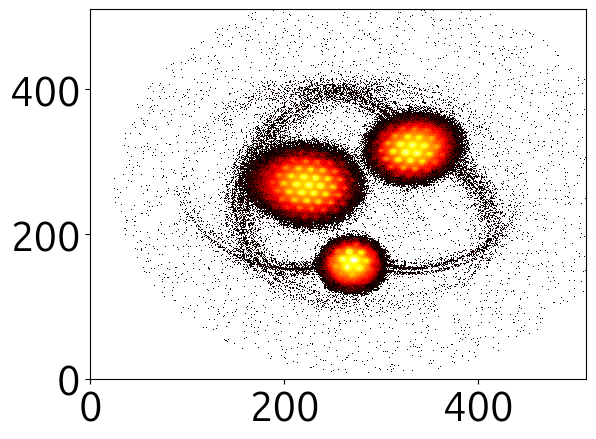

In [76]:
#_6BarSim=SimulatedImages
filename="10Bar_newer.p"
SimPath="/media/argon/Data/CRAB/Sim/10_Bar/"
#SimPath="/media/argon/Data/CRAB/Sim/6_Bar/CRAB/"
#SimPath="/home/argon/Projects/Ilker/gxsim/CRAB/macros/10_Bar_test_hybrid/"
#SimPath="/home/argon/Projects/Ilker/gxsim/CRAB/macros/10_Bar_test_hybrid/CRAB/"
if(os.path.isfile(filename)):
    _SimImages=PickleITRead(filename)
else:
    _SimImages=SimulatedImages(SimPath)
    PickleITDump(_SimImages,filename)
    
_SimImages=SimulatedImages(SimPath,True)
print(_SimImages.keys())

In [5]:
#FixedSimg=Images[1]
#plt.imshow(Simg,cmap=plt.cm.jet,origin='lower',vmin=np.mean(Simg),vmax=np.max(Simg))


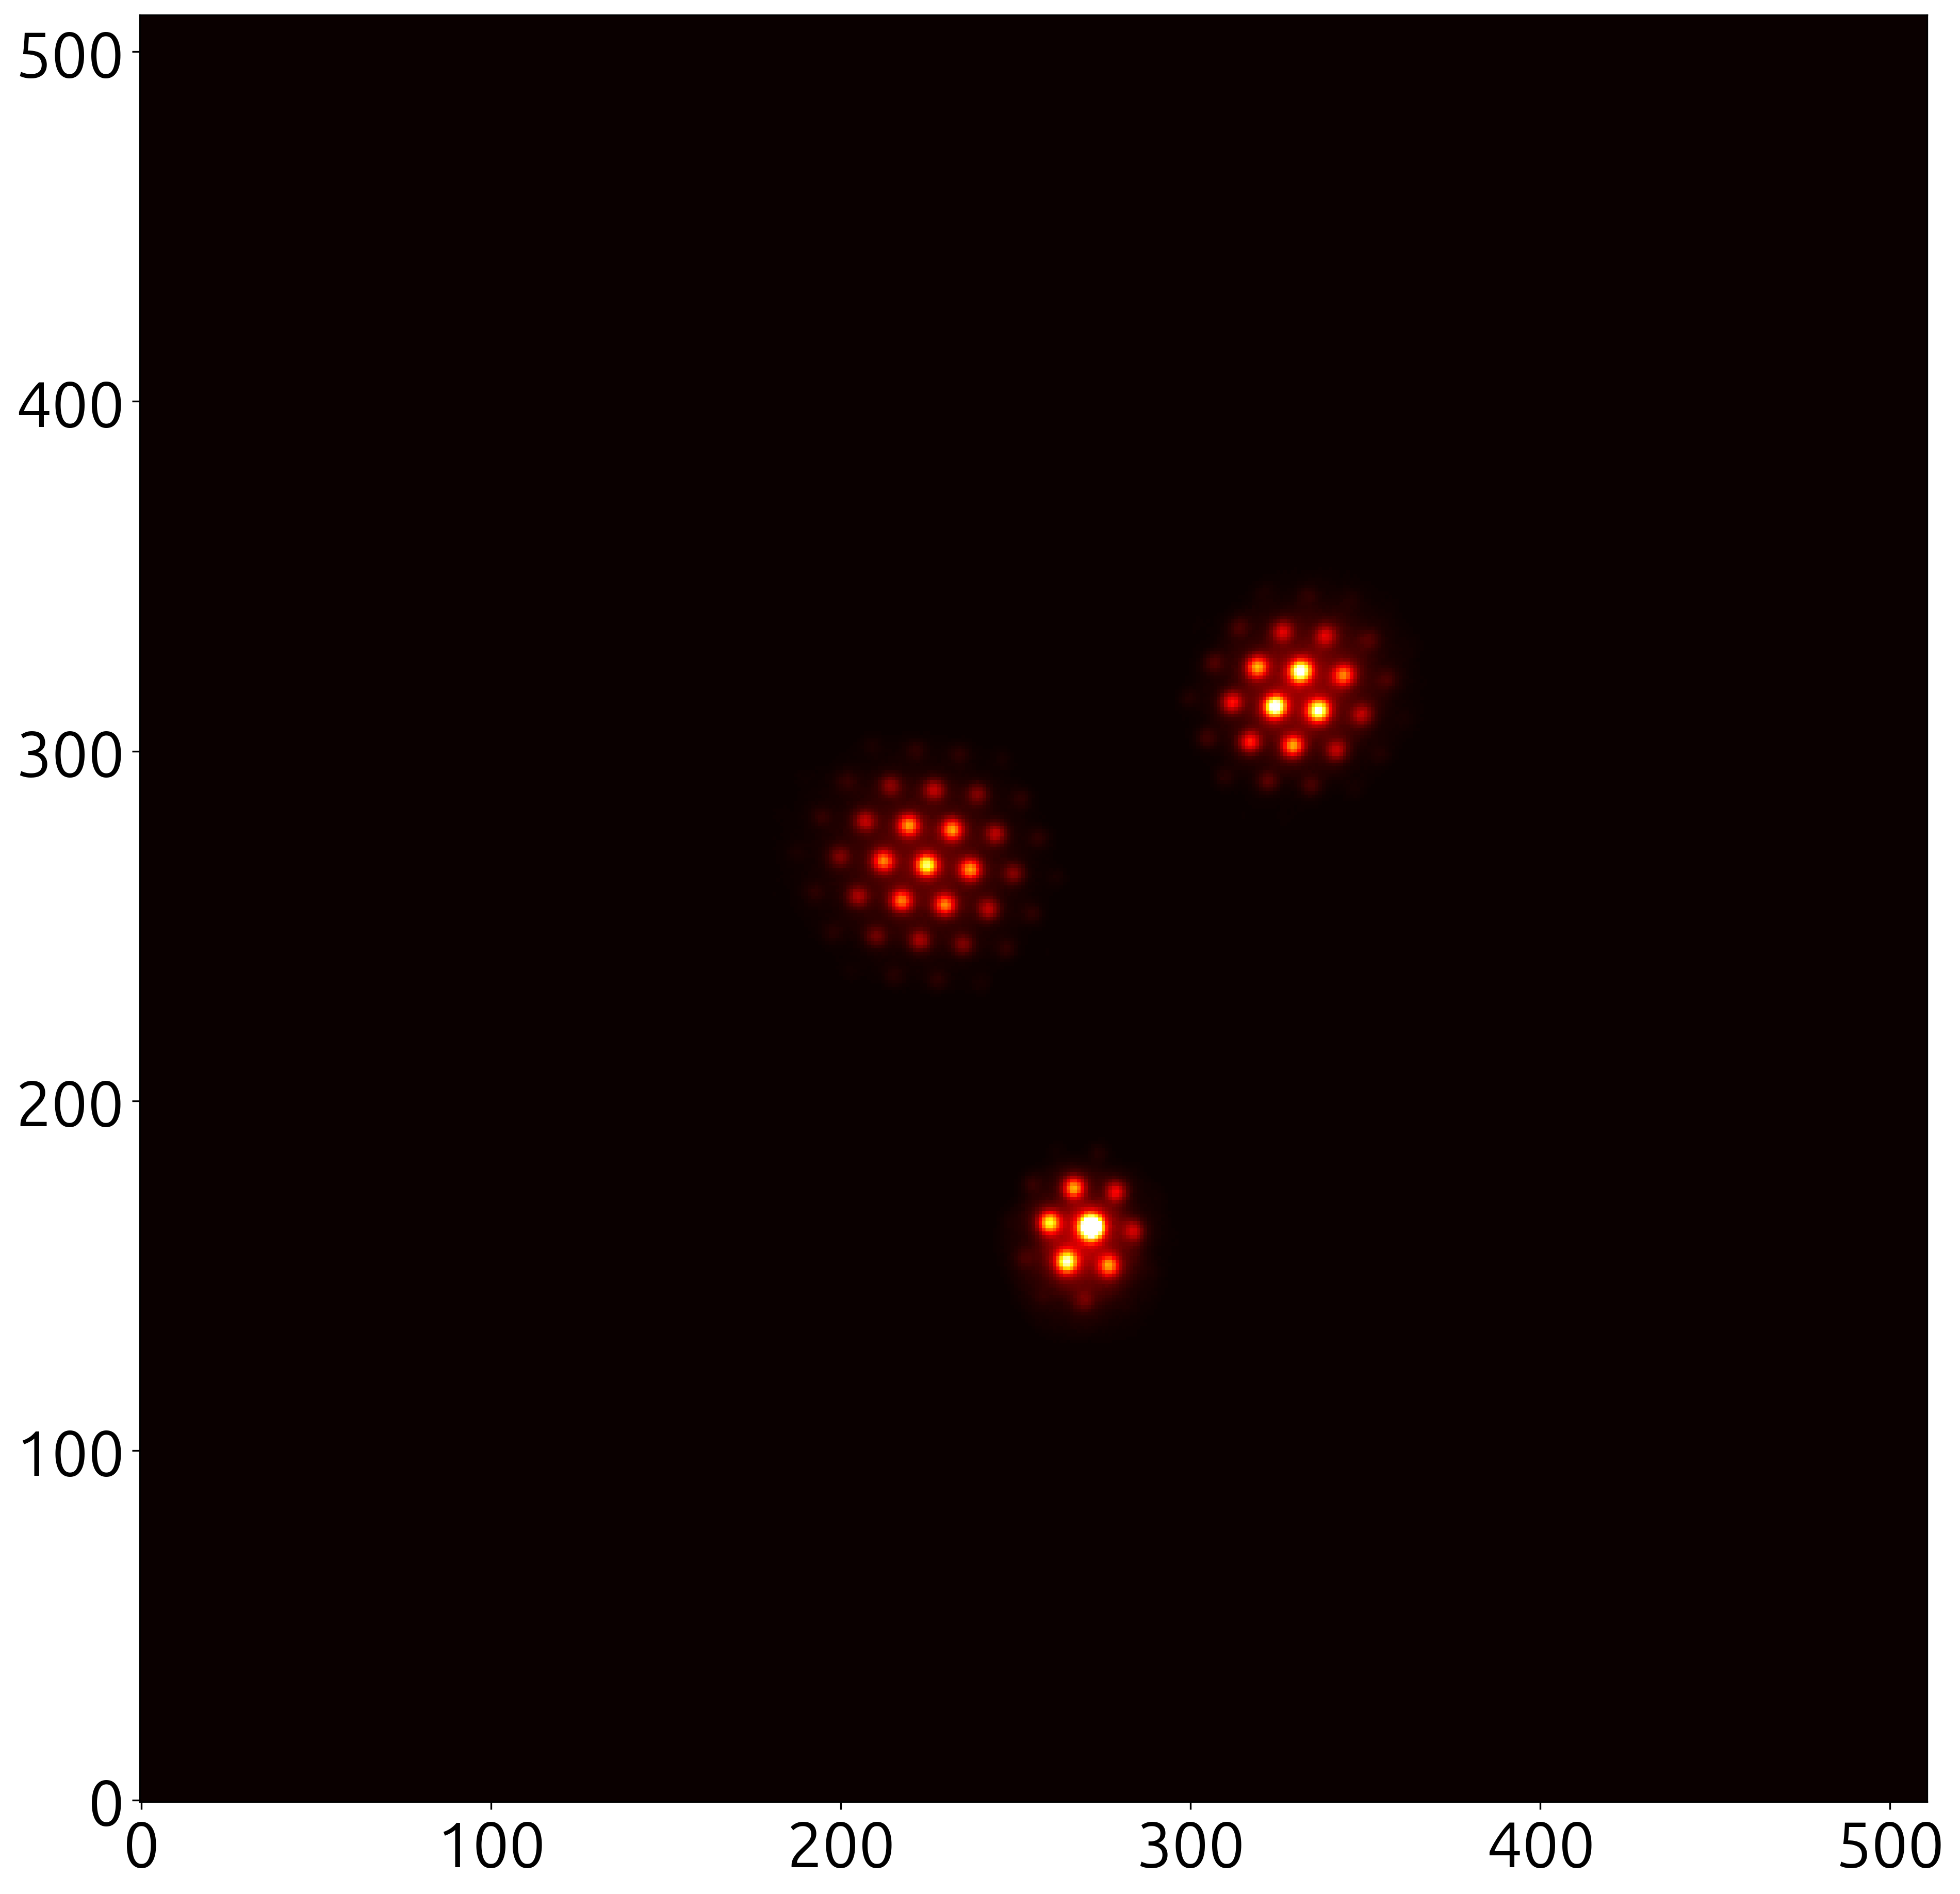

In [83]:
import numpy as np
fig=plt.figure(figsize=(15,15),dpi=300)
singleImg=_SimImages[0]
singleImg=np.rot90(singleImg,1)
singleImg=np.flip(singleImg,0)
PixelShape=singleImg.shape
plt.imshow(singleImg,cmap=plt.cm.hot,origin='lower',vmin=np.mean(singleImg),vmax=np.max(singleImg)/2)


In [6]:
## Average the images
def AvergImage(Images,rangex,Single=True,start=0):
    img=np.zeros(Images[0].shape)
    if (rangex>len(Images.keys())):
        rangex=len(Images.keys())
    # Average only one set
    if(Single):
        for i in range(start,rangex+start):
            img+=Images[i]
        img=img/rangex
        return img
    else: # Average Multiple Sets of Images
        cnt=0
        fImages=[]
        while(cnt<=len(Images.keys())-1):
            img+=Images[cnt]
            if (cnt%(rangex)==0 and cnt>0):
                fImages.append(img/rangex)
                img=np.zeros(Images[0].shape)
            cnt=cnt+1
        return fImages
    
    

In [7]:
Error = lambda Observed,Expected:abs(Observed-Expected)/Expected
def WAverage(img):
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)

    PixelX=xx.ravel()
    PixelY=yy.ravel()
    
    
    weights1d=img.ravel()
    Mult1dX=np.sum(weights1d*PixelX)
    Sumweight1dX=np.sum(weights1d)
    ax=Mult1dX/Sumweight1dX
    
    
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dX=np.sum(weights1d)
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dY=np.sum(weights1d)
    ay=Mult1dY/Sumweight1dY
    
    return ax,ay
#x = np.linspace(0, theImage.shape[0], theImage.shape[0])
#y=  np.linspace(0, theImage.shape[1], theImage.shape[1])
#xx, yy = np.meshgrid(x, y)
#WeightedPixelX=np.average(xx,weights=theImage)
#WeightedPixelY=np.average(yy,weights=theImage)



In [8]:
def WeightedAverage(img,mask,Radius,f):
    ## Method 2 Weighted Average Estimation
    isPrint=f["isPrint"]
    
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)
    
    rr=np.sqrt(xx**2+yy**2)
    
    # Estimate the Max Intensity
    mAx=np.max(img[mask[0]])
    MaxMask2D=mAx==img*mask[0]
    MaxMask1D=mAx==img[mask[0]]
    
    # Estimate the Max Intensity in a given region
    Cmax=(np.where(MaxMask2D)[1],np.where(MaxMask2D)[0])
    
    if(isPrint):
        name=f["Name"]
        print(f" {name} Max is {img[Cmax]} at {Cmax}")
    
    ## Create a Mask that is Centered in Maximum Intensity
    if(len(Cmax[0])>1 or len(Cmax[1])>1):
        print(f"CenterX is {Cmax[0]} and CenterY is {Cmax[1]}")
        CmaxX=np.mean(Cmax[0])
        CmaxY=np.mean(Cmax[1])
        cc=MaskCreate(img.shape,Radius,(CmaxX,CmaxY),False)
    else:    
        cc=MaskCreate(img.shape,Radius,(Cmax[0],Cmax[1]),False)
    
    ## Estimate the Mean
    #Mean=np.average(img[cc[0]],weights=rr[cc[0]])
    
        ## Find the Pixel that is closest to mean
    #ErrorV=Error(img[cc[0]],Mean)
    #MinLoc=np.where(ErrorV==np.min(ErrorV))
    #PixelLoc=np.where(img*cc[0]==img[cc[0]][MinLoc])
    #print(PixelLoc)
   
    WeightedPixelX=np.average(xx[cc[0]],weights=img[cc[0]])
    WeightedPixelY=np.average(yy[cc[0]],weights=img[cc[0]])
    
    PixelX=xx[cc[0]]
    PixelY=yy[cc[0]]
    weightsA=img[cc[0]]
    
    np.average(PixelX*PixelY,weights=weightsA)
    if(isPrint):
        print(f"Weighted Average {(WeightedPixelX,WeightedPixelY)} ")
    return [[WeightedPixelX,WeightedPixelY],[Cmax[0][0],Cmax[1][0]]]
    

In [9]:

#theImage,Radius,NumberOfRings,PixelAmount,centerPoint
def RadialAverageRings(FitV):
    values=FitV["Img"]
    ## Create an array containing with pixel size of the image
    x=np.arange(0,FitV["Img"].shape[0],1)
    
    #Create a coordinate matrix from the pixel size
    xx,yy=np.meshgrid(x,x)
    ## if there is no center point defined then set it at (0,0)
    if FitV["Center"]:
        centerX,centerY=FitV["Center"]
    else:
        centerX,centerY=(0,0)
    R=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    Rings=np.linspace(0,FitV["Radius"],FitV["NumberOfCircles"])
    radialMean = lambda r:(values[(R>=r) & (R<(r+FitV["PixelIncrement"]))]).mean()
    vv=np.array([])
    for i in Rings:
        vv=np.append(vv,radialMean(i))
    return vv,Rings




In [10]:

def Lorentzian(x,a,x0,gamma,offset):
    denominator=np.pi*gamma*(1+((x-x0)/gamma)**2)
    result=((a*1)/(denominator))+offset
    return result

def Gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def Voigt_Fit(x,a,x0,gamma,sigma,offset):
   ## Lorentzian
    if (sigma==0 and gamma>0):
        return Lorentzian(x,a,x0,gamma,offset)
    ## Gaussian
    #elif (gamma==0 and sigma>0):
        #return Gauss(x, a, x0, sigma)
    top=np.vectorize(complex)((x-x0),gamma)
    z=top/(sigma*np.sqrt(2))
    wz=sp.special.wofz(z)
    denom=sigma*np.sqrt(2*np.pi)
    result=a*(np.real(wz)/denom)+offset
    return result

    
def Rsquared(ydata,f):
    mean=np.mean(ydata)
    SStot=np.sum((ydata-mean)**2)
    SSres=np.sum((ydata-f)**2)
    Rsqr=1-SSres/SStot
    return Rsqr


In [11]:


def PeakFinder(data,FitV):
    xlow=FitV["PeakRegion"][0]
    xhigh=FitV["PeakRegion"][1]
    step=FitV["PeakStep"]
    polarity=FitV["polarity"]
    isPrint=FitV["isPrint"]

    if(isPrint):
        print("Running Peak Finder Algorithm ..")
    ## First Get the lenth of the time
    Length=len(data[0])
    YProfile=np.array([])
    XProfile=np.array([])
    
    
    ## Obtain the max and min pixel
    if(not xlow and not xhigh):
        MinPixel=np.min(data[0])
        MaxPixel=np.max(data[0])
    else:
        MinPixel=xlow
        MaxPixel=xhigh
    
    #Start Time
    TempPixel=MinPixel
    if(isPrint):
        print(f"Max time is {MaxPixel}")
        print(f"Min time is {MinPixel}")
        print(f"Event Length is {Length}")

    for i in range(0, Length):
        if(TempPixel>=MaxPixel):
            if(isPrint):
                print("Max Pixel is reached")
            break
            
        PixelMask=(data[0]>=TempPixel) & (data[0]<=TempPixel+step ) 
        
        ## Check if there is any peak here
        if(np.sum(PixelMask)==0):
            TempPixel=TempPixel+step
            continue
         
        ## Obtain the minum
        if(polarity=="pos"):
            Max=np.max(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Max
        else:
            Min=np.min(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Min

        ## Only Negative Pulse        
        XProfile=np.append(XProfile,data[0][PixelMask][AmpMask])
        YProfile=np.append(YProfile,data[1][PixelMask][AmpMask])

        TempPixel=TempPixel+step 
    if(isPrint):
        print(f"Number of Peaks is {len(XProfile)}")
    return XProfile,YProfile
    
#Radius,AmountOfRings,GapDistance
def Obtain1DFit(FitV):
    ## Radius, Precision, 
    ## Obtain Gaussian by getting radial average
    vvv=RadialAverageRings(FitV)
    
    ### Since this is symmetric in X axis flip the  data
    datax=-1*np.flip(vvv[1])
    datay=np.flip(vvv[0])
    datax=np.append(datax,vvv[1])
    datay=np.append(datay,vvv[0])

    #Normalize and Remove the DC offset
    datay=datay/np.max(datay)
    datay=datay-np.mean(datay[(datax>FitV["DCRegion"][0]) & (datax<=FitV["DCRegion"][1])])
    pks=PeakFinder([datax,datay],FitV)
    
    # Empty Peaks
    if(len(pks[1]) ==0):
        print("No Peaks") 
        return  None
    ## Plot the data vs fit
    if(FitV["isPlot"][0]):
        plt.figure(figsize=(15,15),dpi=300)
        plt.plot(datax,datay,'-o',label=FitV["labelx"])
    
    x=np.linspace(np.min(datax),np.max(datax),len(datax))
    R2=0
    #p0=np.max(pks[1]),1,30
    if (FitV["FitType"]=="Lorentz"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parm,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
            plt.xlabel("Pixel")
            plt.ylabel("Intensity (ADC)")
            
        #print(f"RSquared --> {}")
        R2=Rsquared(pks[1],Lorentzian(pks[0],*parm))
    elif (FitV["FitType"]=="Gaussian"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parm,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0)
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
            plt.xlabel("Pixel")
            plt.ylabel("Intensity (ADC)")
            
        
    elif (FitV["FitType"]=="Voigt"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parm,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])  
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
            plt.xlabel("Pixel")
            plt.ylabel("Intensity (ADC)")
    else:
        ## Gauss(x, a, x0, sigma):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parmG,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parmG),linewidth=3,label="Gaussian_"+FitV["labelx"]+"_fit")
        
        ## Lorentzian(x,a,x0,gamma,offset)
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parmL,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parmL),linewidth=3,label="Lorentz_"+FitV["labelx"]+"_fit",color="red")
            plt.xlabel("Pixel")
            plt.ylabel("Intensity (ADC)")
        
        ## Voigt_Fit(x,a,x0,gamma,sigma,offset):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parmV,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parmV),linewidth=3,label="Voigt_"+FitV["labelx"]+"_fit",color="green")
            plt.xlabel("Pixel")
            plt.ylabel("Intensity (ADC)")
        parm=np.array([parmG,parmL,parmV])
    
    if(FitV["isPlot"][0]):
        plt.scatter(pks[0],pks[1],marker='^',color="red",s=200)
        plt.xticks(np.arange(-FitV["Radius"],FitV["Radius"],10))
        plt.xlabel("Pixel")
        plt.ylabel("Intensity (ADC)")
        plt.grid(axis="x")
        plt.legend(loc='upper right',prop={'size':10})

        if(FitV["isVLines"][0]):
            VLines(FitV["isVLines"][1],FitV["isVLines"][2],FitV["isVLines"][3])
        if(FitV["isPlot"][1]):
            plt.show()
    DataX=vvv[1]
    # normalize
    DataY=vvv[0]/np.max(vvv[0])
    
    DataY=DataY-np.mean(DataY[(DataX>FitV["DCRegion"][0]) & (DataX<=FitV["DCRegion"][1])])
    meann=np.mean(DataY[(DataX>FitV["DCRegion"][0]) & (DataX<=FitV["DCRegion"][1])])
    DC=FitV["DCRegion"]
    print(f"Mean {meann} DCX {DC[0]} DCY {DC[1]}")    
    dataPoints={"DataX":DataX,
                "DataY":DataY,
                "PeakX":pks[0],
                "PeakY":pks[1],
                "parm":parm,
                "R2":R2
               }
    
    return parm,pks,R2,dataPoints


   
    


def VLines(startx,endx,increment):
    arry=np.arange(startx,endx,increment)
    for i in arry:
        plt.axvline(i,0,color="red")

In [12]:
## Magnification Formula
Mag=lambda ActualImageSize,AmountOfPixel,PixelSize:ActualImageSize/(AmountOfPixel*PixelSize) 
## Size of the Pixels in Camera
pixelSize=16e-3 #mm
#Calculate the Magnefication
Magnefication=Mag(2.5,10,pixelSize)
print(f" Magnefication is {Magnefication}")

 Magnefication is 15.625


In [13]:
# Obtain Single Fit
## 3 Fit Dictionary and Number of Pictures to analyze and Radius for masking to find the center
def SingleFit(Fitv1,Fitv2,Fitv3,theImg,Values=None,Amount=100,RMask=60,isLowPass=[False,10]):
    ## Average the images
    if(theImg is None):
        theImg=AvergImage(Images,Amount,True)
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    else:
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    #theImage=np.fft.fft2(theImage)*Wiener["WienerandLowPass"]
    #theImage=np.fft.ifft2(theImage)
    #theImage=np.real(theImage)
    
    #Create A Mask Layer
    PixelShape=theImg.shape
    
    ## Check and assign the centers
    if(Fitv1["Center"] is None):
        Fit1CenterPoint=(261,180) #(215,270)
        Fitv1["Center"]=(261,180)
    else:
        Fit1CenterPoint=Fitv1["Center"]
    
    if(Fitv2["Center"] is None):
        Fit2CenterPoint=(298,297) #(298,297)
        Fitv2["Center"]=Fit2CenterPoint
    else:
        Fit2CenterPoint=Fitv2["Center"]
    
    if(Fitv3["Center"] is None):
        Fit3CenterPoint=(215,270)   #(261,180)
        Fitv3["Center"]=(215,270)
    else:
        Fit3CenterPoint=Fitv3["Center"]


    Needle15cmMask=MaskCreate(PixelShape,RMask,Fit3CenterPoint)

    Needle10cmMask=MaskCreate(PixelShape,RMask,Fit2CenterPoint)

    Needle5cmMask=MaskCreate(PixelShape,RMask,Fit1CenterPoint)

    
    ## 0 is Weighted Average
    ## 1 is Max
    indx=0
    
    ## Find the Weighted Pixel Value
    if(isLowPass[0]):
        theImg=LowPass(theImg,isLowPass[1])
        
    if(Fitv1["WeightedMean"]):
        Needle5cm_Center=WeightedAverage(theImg,Needle5cmMask,RMask,Fitv1)
        Fitv1["Center"]=Needle5cm_Center[indx]

    if(Fitv2["WeightedMean"]):
        Needle10cm_Center=WeightedAverage(theImg,Needle10cmMask,RMask,Fitv2)
        Fitv2["Center"]=Needle10cm_Center[indx]
        
    if(Fitv3["WeightedMean"]):
        Needle15cm_Center=WeightedAverage(theImg,Needle15cmMask,RMask,Fitv3)
        Fitv3["Center"]=Needle15cm_Center[indx]
  
    
   

    ## Assign the Center Values
   
    

    ## Get the fits
    f1=Obtain1DFit(Fitv1)
    f2=Obtain1DFit(Fitv2)
    f3=Obtain1DFit(Fitv3)
    if (f1 is None or f2 is None or f3 is None):
        print ("Issue With Peaks") 
        return None
    #print(f1)
    Parms=np.array([f1,f2,f3])
    gammas=np.array([f1[0][2],f2[0][2],f3[0][2]])
    r2=np.array([f1[2],f2[2],f3[2]])
    
    if(Fitv1["isPlot"][0] or Fitv2["isPlot"][0] or Fitv3["isPlot"][0]):
        plt.figure(figsize=(18,18),dpi=300)
        plt.imshow(theImg)
        plt.scatter(*Fitv1["Center"],color="green",s=100)
        plt.scatter(*Fitv2["Center"],color="brown",s=100)
        plt.scatter(*Fitv3["Center"],color="yellow",s=100)
        plt.show()
    ### If Values are not None
    if(Values is not None):
        ## Append All the gamma values
        for i in range (0,3):
            if(r2[i]>0.99): ### Remove anything does not fit well
                Values[i].append(gammas[i])
    else:
        return Parms,gammas,


## run fit using multi-thread  
def MultiProcessManager(Fitv1,Fitv2,Fitv3,NProcess,SharedArray,Amount=100,RMask=60,isLowPass=[True,120]):
    startT=time.time()
    AveragedImages=AvergImage(Images,Amount,False)
    MaxNumEvents=len(AveragedImages)
    
    ## obtain the CPU info
    '''if(NProcess>int(cpu_count())):
        print(f"Your CPU count is {cpu_count()} less than the Number of Process {NProcess } therefore we are selecting the Number of Process to be {cpu_count()}\n")
        NProcess=int(cpu_count())
    '''    
    print("Total Number of Averaged Images to Fit = " +str(MaxNumEvents) )
    print("Number of Processes = " +str(NProcess) )

    
    if(NProcess<0):
        NProcess=MaxNumEvents
        
    if(MaxNumEvents%NProcess==0):   
        NumOfRuns=(int)(MaxNumEvents/NProcess)
    else:
        NumOfRuns=math.ceil(MaxNumEvents/NProcess)
    print("Number of Runs = " +str(NumOfRuns) )

   
    
    print("Starting the Simulation ....")
    
    EventCount=0
    
    Processes=[]
    ## Loop Through of the runs
    NumofEvents=MaxNumEvents
    
    for run in range(0,NumOfRuns):
        print("Starting Run " +str(run+1)+" out of " + str(NumOfRuns))
        
        ### Determine the Number Of Events to Process in each loop
        if(NumofEvents<0): break # break the code if it is negative
            
        reminder=NumofEvents%NProcess
        if (NumofEvents>=NProcess): 
            LoopValue=NProcess 
        else:
            LoopValue=reminder
        print("Expected Number of Events For This Run = " + str(LoopValue))
        #Start the process
        for event in range(0,LoopValue):
            proc=Process(target=SingleFit,args=(Fitv1,Fitv2,Fitv3,AveragedImages[event],SharedArray,Amount,RMask,isLowPass))
            Processes.append(proc)
            #time.sleep(1) ## Introduce 2 seconds delay so it will help to keep results in order
            proc.start()
            EventCount+=1
        
        # Complete     
        for p in Processes:
            p.join()
            #time.sleep(1) ## Introduce 2 seconds delay so it will help to keep results in order

        Processes.clear()
            
        NumofEvents=MaxNumEvents-EventCount
    endT=time.time()
    print("Time elapsed:" +str(endT-startT))
           

In [14]:
def LowPass(img,rad):
    low=MaskCreate(img.shape,rad,[img.shape[0]/2,img.shape[1]/2])
    Filter=np.fft.fftshift(low[0])
    imgreal=np.fft.fft2(img)
    imgreal=imgreal*Filter
    imgreal=np.fft.ifft2(imgreal)
    imgreal=np.real(imgreal)
    return imgreal


In [15]:
#print(Array[2])

In [16]:
NeedleDistances=np.array([4.06,9.18,14.15])


In [17]:
def Sumsof3Gaussian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=TwoDGaussian(xy,*fit1)+TwoDGaussian(xy,*fit2)+TwoDGaussian(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = Sumsof3Gaussian((xx, yy),*popt)
    return flattened.reshape(img.shape[0],img.shape[1]),data_fitted.reshape(img.shape[0],img.shape[1]),[xx,yy],popt




In [18]:
def FitMultiGauss(ss):
    Values={}
    Count=0
    for i in ss:
        theone=ss[i]
        theone=np.rot90(theone,1)
        theone=np.flip(theone,0)
        PixelShape=theone.shape
        print(PixelShape)
        CenterPoint=(215,270) #(215,270)
        Needle15cm_Mask=MaskCreate(PixelShape,50,CenterPoint)
    
        CenterPoint=(298,297) #(298,297)
        Needle10cm_Mask=MaskCreate(PixelShape,50,CenterPoint)

        CenterPoint=(261,180) #(261,180)
        Needle5cm_Mask=MaskCreate(PixelShape,50,CenterPoint)
        ### Initial values

        initialGuess_needle_5cm=np.mean(theone[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0],18, Needle5cm_Mask[2][1],18
        initialGuess_needle_10cm=np.mean(theone[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 20, Needle10cm_Mask[2][1],20
        initialGuess_needle_15cm=np.mean(theone[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 30, Needle15cm_Mask[2][1],30
        offset=0.5
        Fit_3Gaussian=FitSumsof3Gaussian(theone,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)
        Values[Count]=Fit_3Gaussian
        Count+=1
    return Values
    

In [19]:
#Fit_3Gaussian=FitSumsof3Gaussian(theone,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)
Results=FitMultiGauss(_SimImages)

(511, 511)
[8.35008488e+02 2.68978681e+02 8.48396542e+00 1.53405093e+02
 1.01405054e+01 5.75232201e+02 3.33418645e+02 1.32059061e+01
 3.19666113e+02 1.33410783e+01 3.56233206e+02 2.19213507e+02
 1.58091411e+01 2.69191933e+02 1.54751075e+01 1.14954599e-01]
(511, 511)
[8.45497997e+02 2.68582677e+02 8.42427868e+00 1.54569814e+02
 9.61685819e+00 5.79129273e+02 3.34553029e+02 1.30593159e+01
 3.20364521e+02 1.31756918e+01 3.71412677e+02 2.19896696e+02
 1.56691563e+01 2.68438209e+02 1.56597640e+01 1.26280618e-01]
(511, 511)
[7.60578516e+02 2.68351563e+02 8.63375692e+00 1.53728121e+02
 9.68593728e+00 5.59715141e+02 3.34782625e+02 1.32352745e+01
 3.20749382e+02 1.32248214e+01 3.17384154e+02 2.19789598e+02
 1.59496110e+01 2.68588069e+02 1.56188901e+01 9.91139779e-02]
(511, 511)
[7.38720410e+02 2.68235339e+02 8.67787207e+00 1.54754450e+02
 9.59116540e+00 5.77078904e+02 3.34015088e+02 1.31336153e+01
 3.20193220e+02 1.30390509e+01 3.56950336e+02 2.20560078e+02
 1.59681205e+01 2.68787098e+02 1.54701

In [20]:
#2D Histogram

In [21]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")

def GetTransVerseDiffusion(Fit,pixelSize,mag):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=Fit[3][i]*pixelSize
        DTY=Fit[3][i+2]*pixelSize
        DT=((DTX+DTY)/2)*mag
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs
    

In [22]:
def ConvertTransverse(results,pixelSize,Magnefication):
    Diffusionvalues={"4cm":np.array([]),"10cm":np.array([]),"14cm":np.array([])}
    for i in range(0,len(results)):
        rr=results[i]
        cr=GetTransVerseDiffusion(rr,pixelSize,Magnefication)
        Diffusionvalues["4cm"]=np.append(Diffusionvalues["4cm"],cr[0][0])
        Diffusionvalues["10cm"]=np.append(Diffusionvalues["10cm"],cr[0][1])
        Diffusionvalues["14cm"]=np.append(Diffusionvalues["14cm"],cr[0][2])
    return Diffusionvalues
    
    
    

In [23]:
ResultsTrans=ConvertTransverse(Results,pixelSize,Magnefication)



[0.03252949 0.01584197 0.01270612]
1.0072845957486225 1.0981326981041228


Text(0.6, 0.5, 'y = 1.01x + 1.21 ')

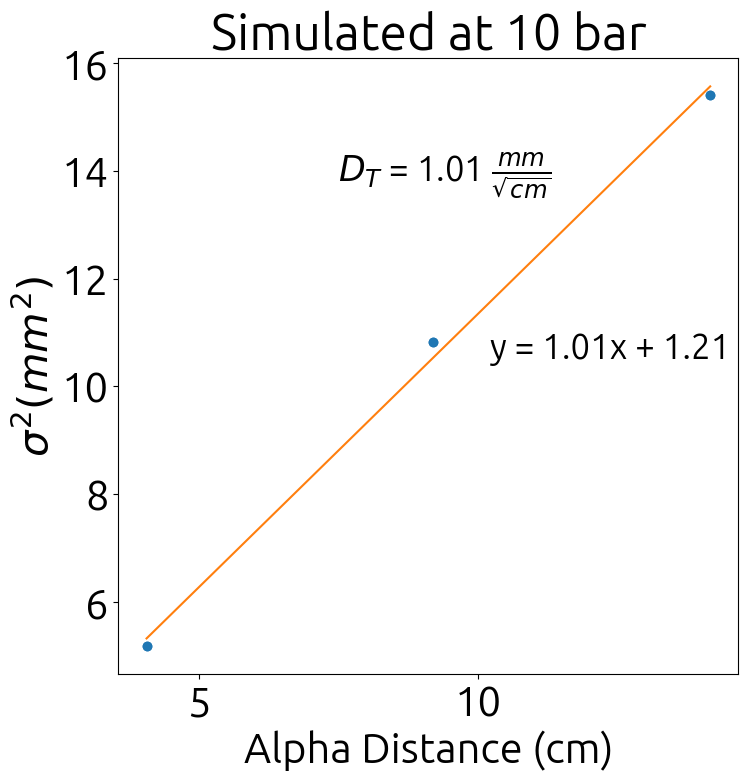

In [24]:
#Diffusion=GetTransVerseDiffusion(Fit_3Gaussian,pixelSize,Magnefication)
plt.figure(figsize=(8,8))

Averaged=np.array([np.mean(ResultsTrans["4cm"])
                  ,np.mean(ResultsTrans["10cm"]),
                  np.mean(ResultsTrans["14cm"])])
Stds=np.array([np.std(ResultsTrans["4cm"]),np.std(ResultsTrans["10cm"]),np.std(ResultsTrans["14cm"])])

plt.title("Simulated at 10 bar")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
#NeedleDistances=np.array([5.46,10.58,15.55])
#NeedleDistances=np.sqrtNeedleDistances)
slope, intercept = np.polyfit(NeedleDistances, Averaged**2, 1)
plt.scatter(NeedleDistances,Averaged**2)
plt.errorbar(NeedleDistances,Averaged**2,yerr=Stds**2,fmt='o',capsize=3)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))

DT=np.round(np.sqrt(slope),2)
print(Stds)
print(np.sqrt(slope),np.sqrt(intercept))

plt.text(0.7,0.85,"$D_{T}$"+f" = {round(np.sqrt(slope),2)} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=25,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=25,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)


In [25]:

#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.figure(figsize=(15,15),dpi=300)
plt.imshow(Fit_3Gaussian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(theone),vmax=np.max(theone))
plt.contour(Fit_3Gaussian[2][0], Fit_3Gaussian[2][1], Fit_3Gaussian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4])
print(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5])
print(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4],NeedleDistances[0],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5],NeedleDistances[1],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10],NeedleDistances[2],pixelSize,Magnefication)



NameError: name 'Fit_3Gaussian' is not defined

<Figure size 4500x4500 with 0 Axes>

In [ ]:
def Lorentzian2D(xy,a,x0,gx,y0,gy):
    x,y=xy
    denominator=np.pi*gx*gy*(1+((x-x0)/gx)**2+((y-y0)/gy)**2)
    result=((a*1)/(denominator))
    return result

def Sumsof3Lorentzian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=Lorentzian2D(xy,*fit1)+Lorentzian2D(xy,*fit2)+Lorentzian2D(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Lorentzian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Lorentzian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = Sumsof3Lorentzian((xx, yy),*popt)
    return flattened.reshape(img.shape[0],img.shape[1]),data_fitted.reshape(img.shape[0],img.shape[1]),[xx,yy],popt    

In [ ]:
## This is a test for Lorentzian

PixelShape=theone.shape
CenterPoint=(215,270) # 14cm away 10 bar
Needle15cm_Mask=MaskCreate(PixelShape,50,CenterPoint)
 
CenterPoint=(298,297) # 10 cm away 10 bar
Needle10cm_Mask=MaskCreate(PixelShape,50,CenterPoint)

CenterPoint=(261,180) # 4cm away
Needle5cm_Mask=MaskCreate(PixelShape,50,CenterPoint)
### Initial values

initialGuess_needle_5cm=np.mean(theone[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0],2, Needle5cm_Mask[2][1],2
initialGuess_needle_10cm=np.mean(theone[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 10, Needle10cm_Mask[2][1],10
initialGuess_needle_15cm=np.mean(theone[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 20, Needle15cm_Mask[2][1],20
offset=0.01



In [ ]:
#Fit_3Lorentzian=FitSumsof3Lorentzian(theone,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)
Fit_3Lorentzian=FitSumsof3Lorentzian(theone,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)

In [ ]:

Diffusion=GetTransVerseDiffusion(Fit_3Lorentzian,pixelSize,Magnefication)

In [ ]:
print(f"Magnefication is {Magnefication}")
#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Lorentzian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(theone),vmax=np.max(theone))
plt.contour(Fit_3Lorentzian[2][0], Fit_3Lorentzian[2][1], Fit_3Lorentzian[1], 5, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Lorentzian[3][2],Fit_3Lorentzian[3][4])
print(Fit_3Lorentzian[3][2+5],Fit_3Lorentzian[3][4+5])
print(Fit_3Lorentzian[3][2+10],Fit_3Lorentzian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Lorentzian[3][2],Fit_3Lorentzian[3][4],NeedleDistances[0],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Lorentzian[3][2+5],Fit_3Lorentzian[3][4+5],NeedleDistances[1],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Lorentzian[3][2+10],Fit_3Lorentzian[3][4+10],NeedleDistances[2],pixelSize,Magnefication)


In [ ]:
print(Diffusion)

In [ ]:
plt.title("Transverse Diffusion")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
#NeedleDistances=np.array([5.46,10.58,15.55])
#NeedleDistances=np.sqrtNeedleDistances)
slope, intercept = np.polyfit(NeedleDistances, Diffusion[0]**2, 1)
plt.scatter(NeedleDistances,Diffusion[0]**2)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))

DT=np.round(np.sqrt(slope),2)

print(np.sqrt(slope),np.sqrt(intercept))

plt.text(0.35,0.85,f"DT = {DT} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=25,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=25,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(f"NeedleDistances is {NeedleDistances} in cm")
print(f"Diffusion is {Diffusion[0]/np.sqrt(NeedleDistances)} mm/sqrt(cm)")

In [ ]:
###### Fitv5cm["Width"]=Fitv10cm["Width"]=[50,50]
Fitv15cm["Width"]=[55,55]
Fitv5cm["WeightedMean"]=Fitv10cm["WeightedMean"]=Fitv15cm["WeightedMean"]=False
Fitv5cm["Center"]=Fitv10cm["Center"]=Fitv15cm["Center"]=None
def Obtain1DNonSymmetricFit(FitV,Mask):
    ## Radius, Precision, 
    ## Obtain Gaussian by getting radial average
    #vvv=RadialAverageRings(FitV)
    #rr[centerX-radius[0] :centerX+radius[0],centerY-radius[1] :centerY+radius[1]]=-1
    name=FitV["Name"]
    print(f"Analyzing  {name}")
    fx=np.arange(FitV["Center"][0]-FitV["Width"][0],FitV["Center"][0]+FitV["Width"][0],1)
    fy=np.arange(FitV["Center"][1]-FitV["Width"][1],FitV["Center"][1]+FitV["Width"][1],1)
   
    
    ### Since this is symmetric in X axis flip the  dataabs
    MaskedImage=(FitV["Img"][Mask[0]])
    
    MaskedImage.resize(len(fx),len(fy))
    #MaskedImage=FitV["Img"]
    if(FitV["isPlot"]):
        plt.figure(figsize=(15,15))
        plt.imshow(MaskedImage)
        #plt.xlim(49,59)
        #plt.ylim(50,58)

        plt.show()
    # Vertical
    dx=np.average(MaskedImage,axis=0)
    # Horizantal
    dy=np.average(MaskedImage,axis=1)
    return [[fx,fy],[dx,dy]]
    
def SingleNonSymmetricFit(Fitv1,Fitv2,Fitv3,theImg,Values=None,Amount=100,RMask=60,isLowPass=[False,10]):
    ## Average the images
    if(theImg is None):
        theImg=AvergImage(Images,Amount,True)
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg

    else:
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    #theImage=np.fft.fft2(theImage)*Wiener["WienerandLowPass"]
    #theImage=np.fft.ifft2(theImage)
    #theImage=np.real(theImage)
    
    #Create A Mask Layer
    PixelShape=theImg.shape
    
    ## Check and assign the centers
    if(Fitv1["Center"] is None):

        Fit1CenterPoint=(261,180)
        Fitv1["Center"]=(261,180)
    else:
        Fit1CenterPoint=Fitv1["Center"]
    
    if(Fitv2["Center"] is None):
        Fit2CenterPoint=(297,298)
        Fitv2["Center"]=Fit2CenterPoint
    else:
        Fit2CenterPoint=Fitv2["Center"]
    
    if(Fitv3["Center"] is None):
        Fit3CenterPoint=(215,270)
        Fitv3["Center"]=(215,270)
       
    else:
        Fit3CenterPoint=Fitv3["Center"]
    
    Needle15cmMask=MaskCreate(PixelShape,Fitv3["Width"],Fit3CenterPoint,sp="Rectangle")

    Needle10cmMask=MaskCreate(PixelShape,Fitv2["Width"],Fit2CenterPoint,sp="Rectangle")

    Needle5cmMask=MaskCreate(PixelShape,Fitv1["Width"],Fit1CenterPoint,sp="Rectangle")

    
    ## 0 is Weighted Average
    ## 1 is Max
    indx=0
    
    ## Find the Weighted Pixel Value
    if(isLowPass[0]):
        theImg=LowPass(theImg,isLowPass[1])
        
    if(Fitv1["WeightedMean"]):
        Needle5cm_Center=WeightedAverage(theImg,Needle5cmMask,RMask,Fitv1)
        Fitv1["Center"]=Needle5cm_Center[indx]

    if(Fitv2["WeightedMean"]):
        Needle10cm_Center=WeightedAverage(theImg,Needle10cmMask,RMask,Fitv2)
        Fitv2["Center"]=Needle10cm_Center[indx]
        
    if(Fitv3["WeightedMean"]):
        Needle15cm_Center=WeightedAverage(theImg,Needle15cmMask,RMask,Fitv3)
        Fitv3["Center"]=Needle15cm_Center[indx]
  

    ## Get the fits
    f1=Obtain1DNonSymmetricFit(Fitv1,Needle5cmMask)
    f2=Obtain1DNonSymmetricFit(Fitv2,Needle10cmMask)
    f3=Obtain1DNonSymmetricFit(Fitv3,Needle15cmMask)
            
    plt.figure(figsize=(18,15),dpi=300)
    ## First Row
    plt.subplot(2,3,1)
    plt.title("4cm_X")
    plt.plot(f1[0][0],f1[1][0])
    plt.subplot(2,3,2)
    plt.title("10cm_X")
    plt.plot(f2[0][0],f2[1][0])
    plt.subplot(2,3,3)
    plt.title("14cm_X")
    plt.plot(f3[0][0],f3[1][0])
    ## Second Row
    plt.subplot(2,3,4)
    plt.title("4cm_Y")
    plt.plot(f1[0][1],f1[1][1])

    plt.subplot(2,3,5)
    plt.title("10cm_Y")
    plt.plot(f2[0][1],f2[1][1])
    plt.subplot(2,3,6)
    plt.title("14cm_Y")
    plt.plot(f3[0][1],f3[1][1])


    plt.show()
theoneLow=LowPass(theone,70)    
SingleNonSymmetricFit(Fitv5cm,Fitv10cm,Fitv15cm,theImg=theoneLow,RMask=40)

In [ ]:
Fitv15cm["Width"]=[45,45]
Fitv5cm["Width"]=[45,45]
Fitv15cm["Center"]=(215,270)
Fitv5cm["Center"]=(261,180)

Fitv10cm["Width"]=[10,10]

mask15=MaskCreate(PixelShape,Fitv15cm["Width"],Fitv15cm["Center"],sp="Rectangle")
mask10=MaskCreate(PixelShape,Fitv10cm["Width"],Fitv10cm["Center"],sp="Rectangle")
mask5=MaskCreate(PixelShape,Fitv5cm["Width"],Fitv5cm["Center"],sp="Rectangle")
allmask=mask15[0]+mask10[0]+mask5[0]
plt.figure(figsize=(15,15),dpi=300)
plt.subplot(2,2,1)
plt.imshow(np.multiply(theone,mask10[0]) ,vmin=np.min(theone),vmax=np.max(theone),origin="lower")
plt.scatter(261,180,color="red")
print(Fitv5cm["Center"])

plt.subplot(2,2,2)
plt.imshow(theone ,vmin=np.min(theone),vmax=np.max(theone))
print(mask5[0])

In [ ]:
Fit1CenterPoint=np.array([261,180])
Fit2CenterPoint=np.array([297,298])

Fit3CenterPoint=np.array([215,270])
print(Fit1CenterPoint-60,Fit2CenterPoint-60,Fit3CenterPoint-60)
print(Fit1CenterPoint+60,Fit2CenterPoint+60,Fit3CenterPoint+60)


In [ ]:
## This is for the Kevin's stuff
from matplotlib.colors import LogNorm
## 2D histogram
bins=15
x=np.arange(0,theone.shape[0],1)
xx,yy=np.meshgrid(x,x)
xx=xx.flatten()
yy=yy.flatten()
zz=theone.flatten()

plt.figure(figsize=(15,15),dpi=300)
h,xedges,yedges,image=plt.hist2d(xx,yy,weights=zz,bins=[np.arange(0,theone.shape[0],bins),np.arange(0,theone.shape[0],bins)],norm=LogNorm())
h=np.rot90(h,1)
h=np.flip(h,0)
plt.contour(h,extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()],linewidths=1,color="red")
plt.show()
#theone11 = cv2.resize(h, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
#theone11 = cv2.normalize(theone11, None, 0, 255, cv2.NORM_MINMAX)
plt.figure(figsize=(15,15),dpi=300)

plt.imshow(h,origin="lower")
plt.show()

In [ ]:
print(h.shape)

In [ ]:
## This is a test for Lorentzian

PixelShape=h.shape
CenterPoint=(215/bins,270/bins)
Needle15cm_Mask=MaskCreate(PixelShape,50/bins,CenterPoint)

CenterPoint=(298/bins,297/bins)
Needle10cm_Mask=MaskCreate(PixelShape,50/bins,CenterPoint)

CenterPoint=(261/bins,180/bins)
Needle5cm_Mask=MaskCreate(PixelShape,50/bins,CenterPoint)
### Initial values

initialGuess_needle_5cm=np.mean(h[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0],3, Needle5cm_Mask[2][1],3
initialGuess_needle_10cm=np.mean(h[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 3, Needle10cm_Mask[2][1],3
initialGuess_needle_15cm=np.mean(h[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 3, Needle15cm_Mask[2][1],3
offset=0.5

Fit_3Gaussian=FitSumsof3Gaussian(h,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)

In [ ]:
Diffusion=GetTransVerseDiffusion(Fit_3Gaussian,pixelSize,Magnefication*bins)
print(Diffusion)
plt.title("Transverse Diffusion")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
#NeedleDistances=np.array([5.46,10.58,15.55])
#NeedleDistances=np.sqrtNeedleDistances)
slope, intercept = np.polyfit(NeedleDistances, Diffusion[0]**2, 1)
plt.scatter(NeedleDistances,Diffusion[0]**2)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))

DT=np.round(np.sqrt(slope),2)

print(np.sqrt(slope),np.sqrt(intercept))

plt.text(0.35,0.85,f"DT = {DT} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(Diffusion[0])


In [ ]:
plt.figure(figsize=(15,15),dpi=300)

#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Gaussian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(h),vmax=np.max(h))
plt.contour(Fit_3Gaussian[2][0], Fit_3Gaussian[2][1], Fit_3Gaussian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4])
print(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5])
print(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4],NeedleDistances[0],pixelSize,Magnefication*bins)
ConvertToDiffusion(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5],NeedleDistances[1],pixelSize,Magnefication*bins)
ConvertToDiffusion(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10],NeedleDistances[2],pixelSize,Magnefication*bins)



In [ ]:
MaskedPicture=theone/np.max(theone)


In [ ]:
### Dr Jones's Request
from matplotlib import transforms

x=np.linspace(0,512,512)
xx,yy=np.meshgrid(x,x)

xlim = xx.min(), xx.max()
ylim = yy.min(), yy.max()
fig, ax0 = plt.subplots(ncols=1, sharey=True, figsize=(15, 15))
plt.imshow(MaskedPicture,vmin=np.mean(MaskedPicture),vmax=np.max(MaskedPicture),origin="lower",cmap="gray")
plt.show()



In [ ]:
plt.imshow(theone)


import seaborn as sns
import pandas as pd
x=np.arange(0,512,1)
plt.hist(theone.flatten(),bins=100)

###### 